In [1]:
from astropy import units as u
import astropy.io.fits as fits
from astropy.table import vstack
from astropy.time import Time
from astropy.timeseries import TimeSeries, LombScargle
from astropy.stats import sigma_clip
from matplotlib import pyplot

import numpy
import pandas
import seaborn

import os
import urllib

import swasputils

In [2]:
SWASP_ID = '1SWASPJ000847.91+052816.7'
FOLDING_PERIOD = 0 # Set to 0 to run Lomb-Scargle
AUTO_FOLDED_PLOTS = 10 # How many of the top Lomb-Scargle periods to plot
SIGMA_CLIP = 4
START_TIME = 0
END_TIME = 0

In [3]:
vespa = pandas.read_csv(os.path.join(swasputils.DATA_LOCATION, 'vespa-export.csv'))

In [4]:
fits_urls = vespa[vespa['SuperWASP ID'] == SWASP_ID.replace(' ', '')]['FITS URL'].unique()

In [5]:
if len(fits_urls) == 0:
    fits_url = 'http://wasp.warwick.ac.uk/lcextract?{}'.format(
        urllib.parse.urlencode(
            {'objid': SWASP_ID.replace('1SWASPJ', '1SWASP J')},
            quote_via=urllib.parse.quote,
        )
    )
else:
    fits_url = fits_urls[0]
fits_url

'https://www.superwasp.org/media/sources/1SWASPJ000847.91%2B052816.7/1SWASPJ000847.91052816.7.fits'

In [6]:
fits_file = fits.open(fits_url)
hjd_col = fits.Column(name='HJD', format='D', array=fits_file[1].data['TMID'] / 86400 + 2453005.5)
lc_data = fits.BinTableHDU.from_columns(fits_file[1].data.columns + fits.ColDefs([hjd_col]))
timeseries = TimeSeries.read(lc_data, time_column='HJD', time_format='jd')

In [7]:
if START_TIME > 0:
    START_TIME = Time(START_TIME / 86400 + 2453005.5, format='jd')
    timeseries = timeseries[timeseries['time'] > START_TIME]
if END_TIME > 0:
    END_TIME = Time(END_TIME / 86400 + 2453005.5, format='jd')
    timeseries = timeseries[timeseries['time'] < END_TIME]

In [8]:
if SIGMA_CLIP > 0:
    ts_flux = sigma_clip(timeseries['TAMFLUX2'], sigma=SIGMA_CLIP)
else:
    ts_flux = timeseries['TAMFLUX2']
ts_data = {
    'time': timeseries.time.jd,
    'flux': ts_flux,
    'err': timeseries['TAMFLUX2_ERR'],
    'camera': timeseries['CAMERA_ID'],
}

In [9]:
def get_folded_ts(orig_ts, period):
    ts = orig_ts.fold(period=period * u.second)
    epoch_length = ts['time'].max() - ts['time'].min()
    ts_out = [ts]
    ts_new = ts.copy()
    ts_new['time'] = ts_new['time'] + epoch_length
    ts_out.append(ts_new)
    ts = vstack(ts_out)
    if SIGMA_CLIP > 0:
        ts_flux = sigma_clip(ts['TAMFLUX2'], sigma=SIGMA_CLIP)
    else:
        ts_flux = ts['TAMFLUX2']

    return {
        'time': ts.time.jd,
        'flux': ts_flux,
        'err': ts['TAMFLUX2_ERR'],
        'camera': ts['CAMERA_ID'],
    }

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Text(0.5, 1.0, '1SWASPJ000847.91+052816.7')

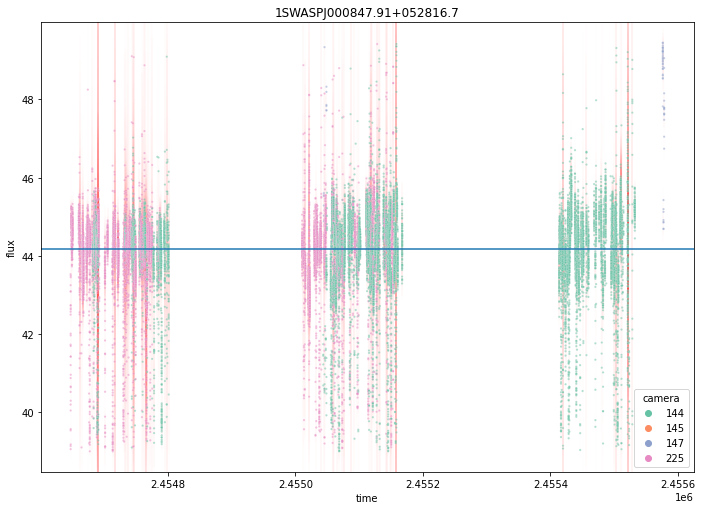

In [10]:
f, ax = pyplot.subplots(figsize=(11.7,8.27))
seaborn.scatterplot(
    data=ts_data,
    x='time',
    y='flux',
    alpha=0.5,
    s=5,
    palette='Set2',
    hue='camera',
)
lims = pyplot.ylim()
pyplot.axhline(numpy.median(ts_flux))

pyplot.errorbar(ts_data['time'], ts_data['flux'], yerr=ts_data['err'], ecolor='red', ls='none', zorder=-1, alpha=0.05, elinewidth=0.1)

pyplot.ylim(lims)
pyplot.title(SWASP_ID)

In [11]:
if FOLDING_PERIOD == 0:
    frequency, power = LombScargle(ts_data['time'], ts_data['flux'], ts_data['err']).autopower()
    periods = pandas.DataFrame({'frequency': frequency, 'power': power, 'period': (1/frequency)*86400}).sort_values('power', ascending=False)
else:
    ls = None
    periods = pandas.DataFrame({'frequency': 1, 'power': [1], 'period': 1})
periods.head(AUTO_FOLDED_PLOTS)


frequency     power         period
6164    0.833592  0.156039  103647.824641
6163    0.833457  0.150665  103664.641032
6165    0.833727  0.148750  103631.013705
6162    0.833322  0.133002  103681.462880
13579   1.836282  0.132018   47051.586215
6166    0.833862  0.130924  103614.208222
13578   1.836147  0.130197   47055.051368
13580   1.836418  0.123248   47048.121571
1250    0.169098  0.121212  510945.233906
12328   1.667116  0.119576   51826.014114

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


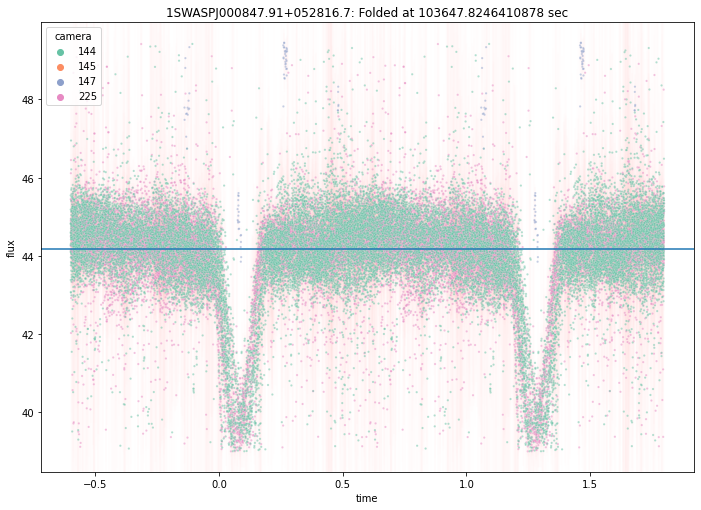

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


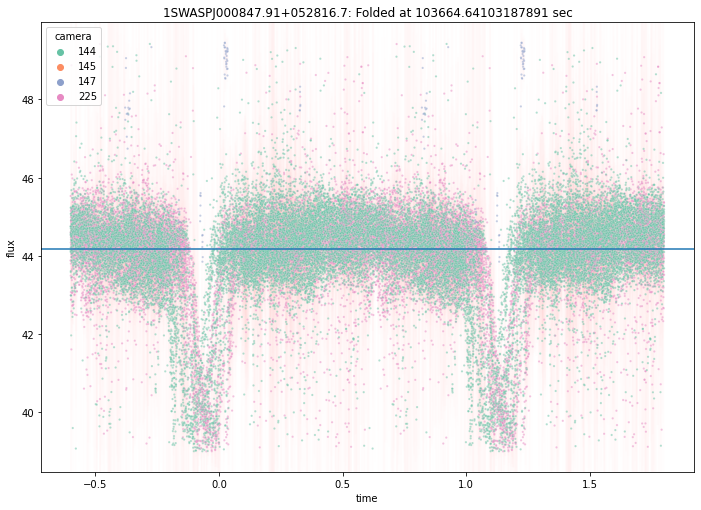

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


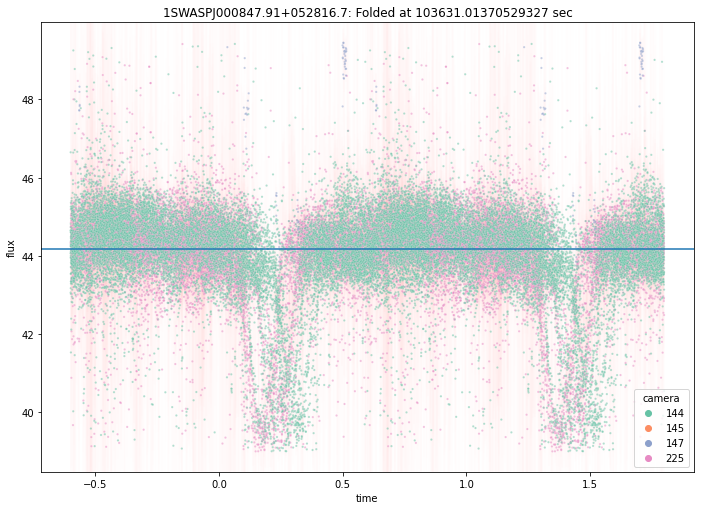

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


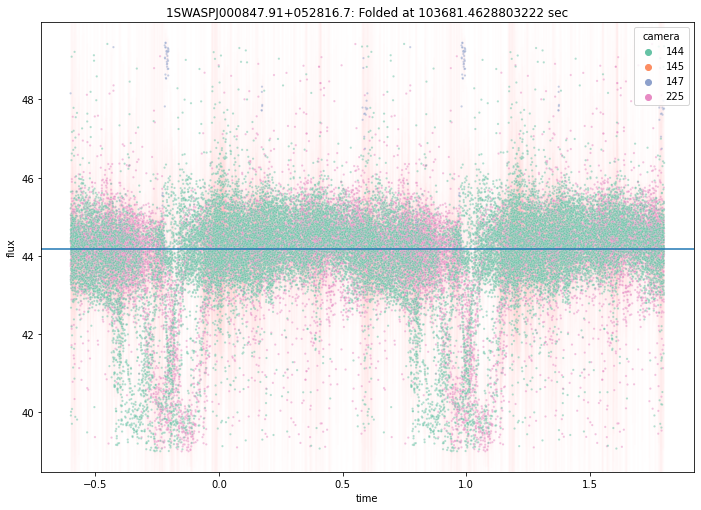

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


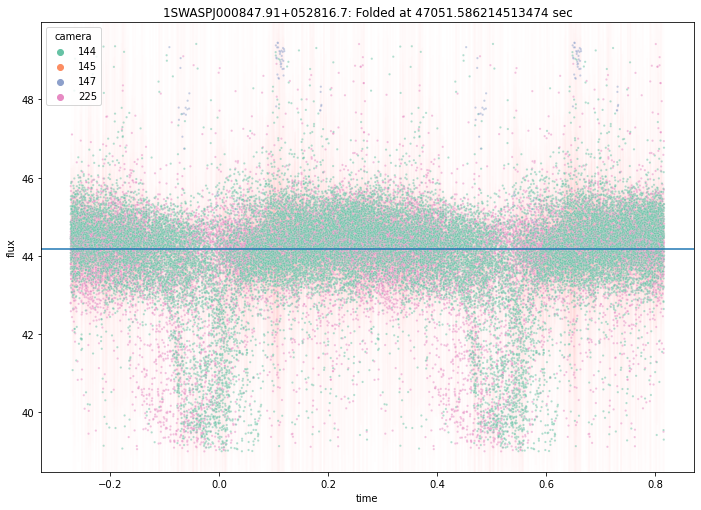

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


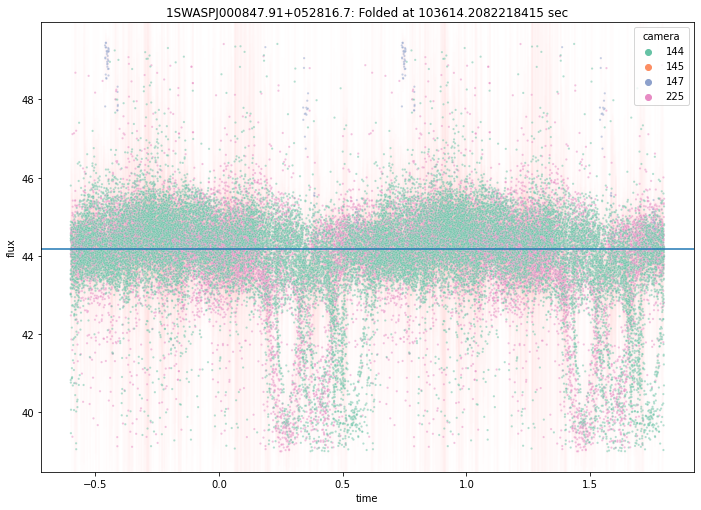

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


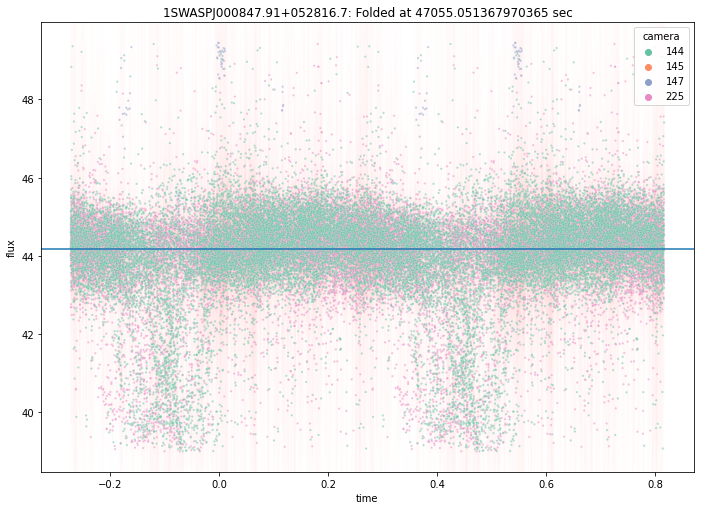

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


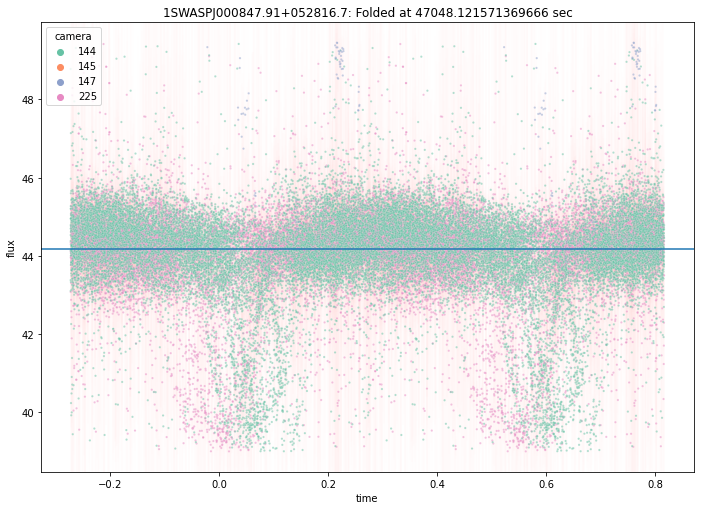

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


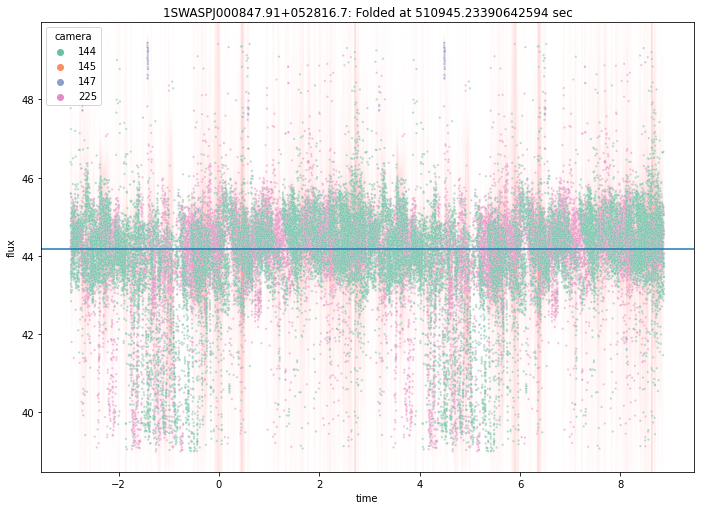

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


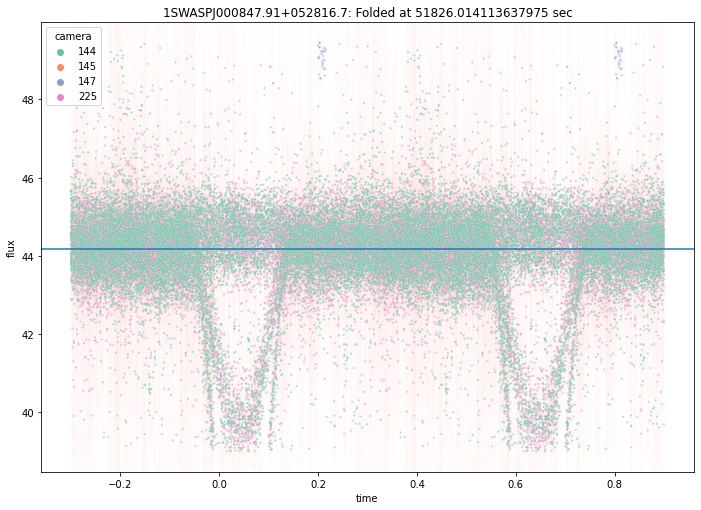

In [12]:
for i, period_row in periods.head(AUTO_FOLDED_PLOTS).iterrows():
    period = period_row['period']
    folded_ts_data = get_folded_ts(timeseries, period)
    f, ax = pyplot.subplots(figsize=(11.7,8.27))
    seaborn.scatterplot(
        data=folded_ts_data,
        x='time',
        y='flux',
        alpha=0.5,
        s=5,
        palette='Set2',
        hue='camera',
    )
    lims = pyplot.ylim()
    pyplot.axhline(numpy.median(folded_ts_data['flux']))

    pyplot.errorbar(folded_ts_data['time'], folded_ts_data['flux'], yerr=folded_ts_data['err'], ecolor='red', ls='none', zorder=-1, alpha=0.05, elinewidth=0.1)

    pyplot.ylim(lims)
    pyplot.title(f'{SWASP_ID}: Folded at {period} sec')
    pyplot.show()